<a href="https://colab.research.google.com/github/athiq-ahmed/Pytorch/blob/master/Captcha_recognition_using_PyTorch_(Convolutional_RNN_%2B_CTC_Loss).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Sun Sep  6 06:35:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   159  100   159    0     0    226      0 --:--:-- --:--:-- --:--:--   226
100 8863k  100 8863k    0     0  6935k      0  0:00:01  0:00:01 --:--:-- 44.5M


In [4]:
!unzip -qq captcha_images_v2.zip

### Config.py

In [5]:
DATA_DIR = '/content/captcha_images_v2'
BATCH_SIZE = 8
IMAGE_WIDTH = 300
IMAGE_HEIGHT = 75
NUM_WORKERS = 4
EPOCHS = 10
DEVICE = "cuda"

In [6]:
import glob
# glob.glob('/content/captcha_images_v2/*.png')

### Dataset.py

In [7]:
import albumentations # for augmentations
import torch
import numpy as np

from PIL import Image
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [8]:
class ClassificationDataset:
  def __init__(self, image_paths, targets, resize=None):
    self.image_paths = image_paths
    self.targets = targets
    self.resize = resize
    self.aug = albumentations.Compose([albumentations.Normalize(always_apply=True)])

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, item):
    image = Image.open(self.image_paths[item]).convert("RGB")
    targets = self.targets[item]

    if self.resize is not None:
      image = image.resize((self.resize[1], self.resize[0]), resample=Image.BILINEAR)

    image = np.array(image)
    augmented = self.aug(image=image)
    image = augmented["image"]
    image = np.transpose(image, (2,0,1)).astype(np.float32)

    return {
        "images": torch.tensor(image, dtype=torch.float),
        "targets": torch.tensor(targets, dtype=torch.long)
    }

### train.py

In [9]:
import os
import glob
import torch
import numpy as np

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics


def run_traning():
  image_files = glob.glob('/content/captcha_images_v2/*.png')
  targets_orig = [x.split('/')[-1][:4] for x in image_files]  # "'../../../abcd.png"
  targets = [[c for c in x] for x in targets_orig]  # abcd --> [a, b, c, d]
  targets_flat = [c for clist in targets for c in clist]

  lbl_enc = preprocessing.LabelEncoder()
  lbl_enc.fit(targets_flat)
  targets_enc = [lbl_enc.transform(x) for x in targets]
  targets_enc = np.array(targets_enc) + 1


  (train_imgs, test_imgs, train_targets, test_targets, train_orig_targets, test_orig_targets) = \
  model_selection.train_test_split(image_files, targets_enc, targets_orig, test_size=0.1, random_state=42)

  train_dataset = ClassificationDataset(image_paths=train_imgs, targets=train_targets, resize=(IMAGE_HEIGHT, IMAGE_WIDTH))
  test_dataset = ClassificationDataset(image_paths=test_imgs, targets=test_targets, resize=(IMAGE_HEIGHT, IMAGE_WIDTH))

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)


  # print(targets)
  # print('*'*100)
  # print(np.unique(targets_flat))
  # print('*'*100)
  # print(targets_enc)
  # print('*'*100)
  # print(len(lbl_enc.classes_))


run_traning()

### view.py

In [10]:
import os
import glob
import torch
import numpy as np

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

image_files = glob.glob('/content/captcha_images_v2/*.png')
targets_orig = [x.split('/')[-1][:4] for x in image_files]  # "'../../../abcd.png"
targets = [[c for c in x] for x in targets_orig]  # abcd --> [a, b, c, d]
targets_flat = [c for clist in targets for c in clist]

lbl_enc = preprocessing.LabelEncoder()
lbl_enc.fit(targets_flat)
targets_enc = [lbl_enc.transform(x) for x in targets]
targets_enc = np.array(targets_enc) + 1


(train_imgs, test_imgs, train_targets, test_targets, train_orig_targets, test_orig_targets) = \
model_selection.train_test_split(image_files, targets_enc, targets_orig, test_size=0.1, random_state=42)

train_dataset = ClassificationDataset(image_paths=train_imgs, targets=train_targets, resize=(IMAGE_HEIGHT, IMAGE_WIDTH))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


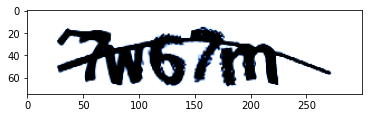

In [11]:
# train_dataset[0]
npimg = train_dataset[200]["images"].numpy()
# npimg
# npimg.shape
# np.transpose(npimg, (1,2,0)).shape
plt.imshow(np.transpose(npimg, (1,2,0)))

### engine.py

In [13]:
from tqdm import tqdm
import torch

def train_fn(model, data_loader, optimizer):
  model.train()
  fin_loss = 0
  tk = tqdm(data_loader, total=len(data_loader))
  for data in tk:
    for k, v in data.items():
      data[k] = v.to(DEVICE)
    optimizer.zero_grad()
    _, loss = model(**data)
    loss.backward()
    optimizer.step()
    fin_loss += loss
  return fin_loss / len(data_loader)

def train_fn(model, data_loader, optimizer):
  model.eval()
  fin_loss = 0
  fin_preds = []
  tk = tqdm(data_loader, total=len(data_loader))
  for data in tk:
    for k, v in data.items():
      data[k] = v.to(DEVICE)

    preds, loss = model(**data)
    fin_loss += loss
    fin_preds.append(preds)
  return fin_preds, fin_loss / len(data_loader)

### model.py

In [24]:
import torch
from torch import nn
from torch.nn import functional as F

class CaptchaModel(nn.Module):
  def __init__(self, num_chars):
    super(CaptchaModel, self).__init__()
    self.conv_1 = nn.Conv2d(3, 128, kernel_size=(3,3), padding=(1,1))
    self.max_pool_1 = nn.MaxPool2d(kernel_size=(2,2))
    self.conv_2 = nn.Conv2d(128, 64, kernel_size=(3,3), padding=(1,1))
    self.max_pool_2 = nn.MaxPool2d(kernel_size=(2,2))

  def forward(self, images, targets=None):
    bs, c, h, w = images.size()
    print(bs, c, h, w)
    x = F.relu(self.conv_1(images))
    print(x.size())
    x = self.max_pool_1(x)
    print(x.size())
    x = F.relu(self.conv_2(x))
    print(x.size())
    x = self.max_pool_2(x) # [1, 64, 18, 75]
    print(x.size())
    x = x.permute(0,3,1,2)
    print(x.size())
    x = x.view(bs, x.size(1), -1)
    print(x.size())
    return x, None

if __name__ == "__main__":
  cm = CaptchaModel(19)
  img = torch.rand(1,3,75,300)
  target = torch.randint(1,20,(1,5))
  x, loss = cm(img, target)


1 3 75 300
torch.Size([1, 128, 75, 300])
torch.Size([1, 128, 37, 150])
torch.Size([1, 64, 37, 150])
torch.Size([1, 64, 18, 75])
torch.Size([1, 75, 64, 18])
torch.Size([1, 75, 1152])
